# Before Start
I first chose google landmark dataset for my final project.
I knew that size of dataset was about 100MB.
But in reality, it was 97.7GB which is too big to train at home.
So I decided to change dataset, while maintaining concept of image classification.
I chose to classify fruits, and dataset has given from kaggle.
Total size is reasonable(760MB) to be trained at home.  
# Data Description
Total number of images: 90483.

Training set size: 67692 images (one fruit or vegetable per image).

Test set size: 22688 images (one fruit or vegetable per image).

Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)

Number of classes: 131 (fruits and vegetables).

Image size: 100x100 pixels.
# Discussion
As images are 100x100 pixels, their size is quite bigger than former homerworks. Using ANN for fruits dataset may take long time for training, while remaining on underfitting. As an image file, the best way to extract meaningful feature from itself is using convolution layer. I chose use convolution neural network for my final project, as I mentioned on proposal.
# Start of final project
Visualize data using tensorboard

In [1]:
%reload_ext tensorboard
%tensorboard --logdir runs --port 6006 --host 0.0.0.0

Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
writer = SummaryWriter()
%matplotlib inline

Use GPU for fast training

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Set path for training and test dataset, load image files using ImageFolder and count the class number, from data description in Kaggle,  

---
Total number of images: 90483.  
Training set size: 67692 images (one fruit or vegetable per image).  
Test set size: 22688 images (one fruit or vegetable per image).  
Number of classes: 131 (fruits and vegetables).


---
Let me check I load all data and count all classes

In [4]:
train_path = "./fruits-360/Training/"
test_path = "./fruits-360/Test/"
dataset = ImageFolder(train_path, transform=transforms.ToTensor())
testset = ImageFolder(test_path, transform=transforms.ToTensor())
print("train size : ",len(dataset))
print("test size : ", len(testset))
print("number of classes: ", len(dataset.classes))

train size :  67692
test size :  22688
number of classes:  131


All data loaded, check the shape of img, from the data description in Kaggle, 

---
Image size: 100x100 pixels.

---

Also show one example of trainset

torch.Size([3, 100, 100])
Pomelo Sweetie


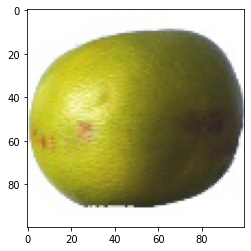

In [5]:
img, label = dataset[np.random.randint(67692)]
print(img.shape)
plt.imshow(img.permute(1,2,0))
print(dataset.classes[label])

Split train and validation set

In [6]:
val_size = len(dataset)//5
train_size = len(dataset) - val_size

trainset, valset = random_split(dataset, [train_size, val_size])
print(len(trainset), len(valset))

54154 13538


Load data using dataloader

In [7]:
batch_size = 64
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valloader = DataLoader(valset, batch_size*2, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size*2, num_workers=4, pin_memory=True)

Make CNN network for classification

In [8]:
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, 131))
        
    def forward(self, xb):
        return self.network(xb)

In [9]:
cnn = CnnModel()
cnn.to(device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [10]:
import torch.optim as optim
# loss list for learning curve

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
global_step = 0
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        writer.add_scalar('Loss/train', loss.item(), global_step)
        global_step += 1
        mini_batch = 100
        if i % mini_batch == mini_batch - 1:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / mini_batch))
            running_loss = 0.0
    # check val accuracy every epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))
writer.close()
print('Finished Training')

[1,   100] loss: 4.875
[1,   200] loss: 4.870
[1,   300] loss: 4.866
[1,   400] loss: 4.859
[1,   500] loss: 4.358
[1,   600] loss: 3.292
[1,   700] loss: 2.772
[1,   800] loss: 2.245
Accuracy of the network on the validation images: 40 %
[2,   100] loss: 1.664
[2,   200] loss: 1.316
[2,   300] loss: 1.000
[2,   400] loss: 0.773
[2,   500] loss: 0.620
[2,   600] loss: 0.546
[2,   700] loss: 0.399
[2,   800] loss: 0.378
Accuracy of the network on the validation images: 90 %
Finished Training


Show test accuracy

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 74 %


# Discussion
Although you expect that the “size” of your project should be equal to about the amount of work required for two homework assignments, this project was quite big than my thought. Dataset is too big for individual student, so accuracy was quite low than expected. Also, I spend to much time to adjust network, but in reality, I found that adjusting hyperparameter affects training speed and accuracy a lot. I stopped training early because of lack of computational resource, but if I had more resource, I could got higher performance